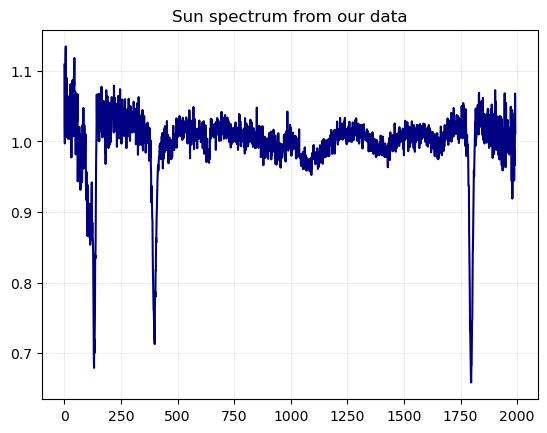

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imageio import imwrite, imread
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c, e
import sympy as sp
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm, MinMaxInterval

sun_data = np.loadtxt("flatlined/Flatlined_Regulus.txt", comments="#")

fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(sun_data, color="navy", label="Vega spectrum")
frame.set_title("Sun spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

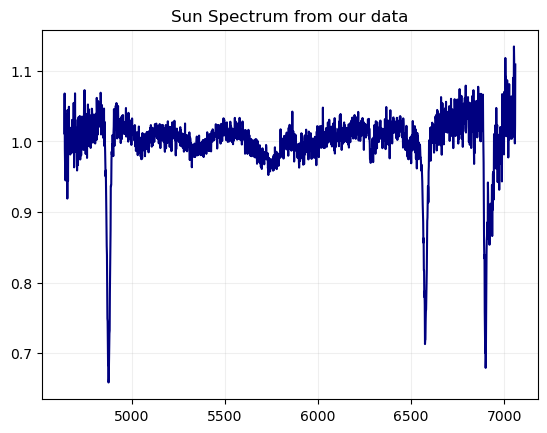

In [41]:
x_range = np.arange(0, np.size(sun_data))
x_range_a = x_range*-1.217+7060

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(x_range_a,sun_data,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Sun Spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

[array([-2.00e-01,  4.88e+03,  5.00e+00]), array([-2.00e-01,  6.55e+03,  5.00e+00]), array([-2.0e-01,  6.9e+03,  5.0e+00])]
Parameters: [-3.42119701e-01  4.87326033e+03  7.68997802e+00 -2.67187674e-01
  6.57608770e+03  9.63615802e+00 -1.97603191e-01  6.90912676e+03
  1.57743288e+01  1.00872301e+00]
Gaussian parameters: [[-3.42119701e-01  4.87326033e+03  7.68997802e+00]
 [-2.67187674e-01  6.57608770e+03  9.63615802e+00]
 [-1.97603191e-01  6.90912676e+03  1.57743288e+01]]


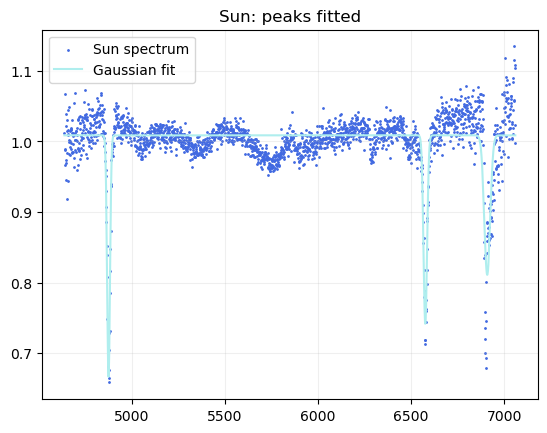

In [42]:
def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on a straight line"""
    num_gaussians = (len(params)-1) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    z = params[-1:]
    y+=z
    return y

D1=np.array([-0.2,4880,5])
D2=np.array([-0.2,6550,5]) #Na I
D3 = np.array([-0.2,6900,5]) #?


# arcturus_miles_line=alsbaseline(arcturus_miles_line, remove=False, lam=1)

initial_gaussians = [D1, D2, D3]
print(initial_gaussians)
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [1]

beta, pcov = curve_fit(f_superior, x_range_a, sun_data, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
z = beta[-1]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)
# print("Line parameters:", line_params)

# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_a, sun_data, color="royalblue", label="Sun spectrum", s=1)
frame.plot(x_range_a, f_superior(x_range_a, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Sun: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[18.10851438 22.69141805 37.14570566]
H-beta peak equivalent width: 18.108514382528206
H-alpha peak equivalent width: 22.69141805481524
Oxygen peak equivalent width: 37.14570565737046
Error in FWHMs: 0.5563474394724631


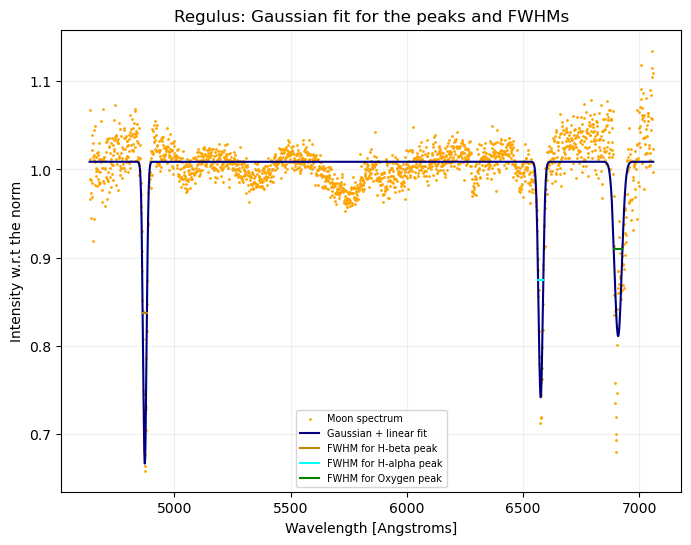

In [43]:
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
PeakDescriptions=["H-beta","H-alpha","Oxygen"]
PeakColors=["darkgoldenrod", "cyan", "green"]
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,sun_data, color="orange", label="Moon spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range_a, *beta),color="navy", label="Gaussian + linear fit")

p=0

PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))

    # getting the exponential fit data to know the y-coordinates of FWHM plot
    

    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(fwhm_x,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1

frame.set_title("Regulus: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)